# MODELO DE PREDICCIÓN TESIS

## 1. Lectura y Preparación de Datos

**Creación de variables:**

_BWEiny_ciclo_: se calcula como la diferencia consecutiva (.diff()) de 'BWEiny CUM por pozo'.
Esto extrae la “inyección de vapor en este ciclo” (en vez del acumulado).

- .diff() calcula la diferencia entre un valor y el valor precedente (lag) en una serie o columna.

x 
i
′
​
 =x 
i
​
 −x 
i−1
​
 (para i≥2)

_SOR_lag_: se crea con shift(1) para obtener el SOR del ciclo anterior (lag).


_pico_lag_: se obtiene el pico de producción del ciclo anterior.
Permite que el modelo use la información de “pico pasado” para predecir el nuevo ciclo.

## 2. Definición de Features y Targets

**Partición train/test:**

Se toma el 80% de datos para entrenar (X_train, y_train) y el 20% para evaluar (X_test, y_test).

## 3 . Entrenamiento del Modelo Multi-output (RandomForest + GridSearchCV)

**1. Definición del RandomForestRegressor:**

random_state=42 para reproducibilidad.

param_grid: un diccionario que define las combinaciones de hiperparámetros a probar:
n_estimators: número de árboles (100, 200)

max_depth: profundidad máxima (10, 20, o sin límite con None)

min_samples_split: mínimo de muestras para dividir un nodo (2, 5)

min_samples_leaf: mínimo de muestras en una hoja (1, 2) 


**2. GridSearchCV:**

cv=3: se hace una validación cruzada de 3 particiones.

scoring='r2': la métrica a optimizar es el coeficiente de determinación (R²).

n_jobs=-1: para usar todos los núcleos disponibles y acelerar.


**3. MultiOutputRegressor:**

Crea un “RandomForestRegressor” por cada variable objetivo (Np, PIR).
Cada uno usa GridSearchCV para buscar los mejores hiperparámetros.
Ajuste (fit):

Entrena con X_train, y_train, probando combinaciones y usando CV para cada “salida”.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

##################################################
# SECCIÓN 1: LECTURA Y PREPARACIÓN DE DATOS
##################################################

data = pd.read_excel("C:/Users/57305/Data science/data_copia1.xlsx")

# 1) Ordenar por pozo (UNIQUEID) y ciclo
data = data.sort_values(by=['UNIQUEID', 'CICLO CORREGIDO WINJBTU'])

# 2) Crear BWEiny_ciclo: diferencia entre valores consecutivos de 'BWEiny CUM por pozo'
data['BWEiny_ciclo'] = data.groupby('UNIQUEID')['BWEiny CUM por pozo'].diff()

# 3) Crear SOR_lag: el SOR del ciclo anterior
data['SOR_lag'] = data.groupby('UNIQUEID')['SOR por ciclo'].shift(1)

# 4) Crear pico_lag: el PICO DE PRODUCCIÓN del ciclo anterior (no log)
data['pico_lag'] = data.groupby('UNIQUEID')['PICO DE PRODUCCIÓN'].shift(1)

# Eliminamos filas con NaN en las columnas que hemos creado
data = data.dropna(subset=['BWEiny_ciclo', 'SOR_lag', 'pico_lag'])

##################################################
# SECCIÓN 2: DEFINIR FEATURES Y TARGETS
##################################################
# En este modelo, 'pico_lag' es la variable (real) del ciclo anterior.
# Salidas: 'Np por ciclo (total)', 'PIR por ciclo'.

feature_cols = [
    'CICLO CORREGIDO WINJBTU',
    'qi',
    'Wp por ciclo cum',
    'Np por ciclo cum',
    'BWEiny_ciclo',
    'SOR_lag',
    'pico_lag'  # <--- Tomamos el pico del ciclo anterior (valor crudo, no log)
]

target_cols = [
    'Np por ciclo (total)',
    'PIR por ciclo'
]

# Elimina filas con NaN en features o targets
data = data.dropna(subset=feature_cols + target_cols)

X = data[feature_cols].copy()
y = data[target_cols].copy()

# Partición train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##################################################
# SECCIÓN 3: ENTRENAMIENTO MODELO MULTI-OUTPUT
##################################################

# Definimos un RandomForestRegressor con GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

# Añadir el código que nos dice cuales son los mejores parámetros

model_multi = MultiOutputRegressor(grid_search)
model_multi.fit(X_train, y_train)

# Evaluación en test
y_pred = model_multi.predict(X_test)

rmse_vals = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("RMSE [Np, PIR]:", rmse_vals)

r2_weighted = r2_score(y_test, y_pred, multioutput='variance_weighted')
print(f"R² ponderado: {r2_weighted:.2f}")

# R² individual
r2_indiv = r2_score(y_test, y_pred, multioutput='raw_values')
print("R² individual [Np, PIR]:", r2_indiv)

RMSE [Np, PIR]: [3834.60474065    4.06549083]
R² ponderado: 0.74
R² individual [Np, PIR]: [0.73870875 0.73098829]


El modelo Multi-output entrena un estimador (p. ej. RandomForest) por cada variable objetivo. 
Si tenemos \\( m \\) salidas, \\( y \in \mathbb{R}^{n \times m} \\), se crean \\( m \\) estimadores:

$$
\text{Sea } Y = \bigl[y^{(1)}, y^{(2)}, \dots, y^{(m)}\bigr],
$$

donde cada \\( y^{(j)} \in \mathbb{R}^n \\).

El **árbol** (o RandomForest) \\( f_j \\) aprende a minimizar el error para la salida \\( y^{(j)} \\):
\\[
\min \sum_{i=1}^{n} \bigl(y^{(j)}_i - \hat{y}^{(j)}_i\bigr)^2.
\\]

Así, MultiOutputRegressor produce la predicción:

$$
\hat{Y} = \Bigl(f_1(X), \; f_2(X), \; \dots,\; f_m(X)\Bigr).
$$


## 4. Importancia de features

**model_multi.estimators_:**
Cada elemento es un GridSearchCV para una variable (Np o PIR).

**best_estimator_:**
Dentro del GridSearchCV, se obtiene el RandomForest con la mejor combinación de hiperparámetros.

**feature_importances_:**
Vector que indica cuánto contribuye cada feature en la predicción. A mayor valor, más relevante es la variable.


--- Importancia de Features para la salida 'Np por ciclo (total)' ---
pico_lag: 0.6043
Np por ciclo cum: 0.1237
CICLO CORREGIDO WINJBTU: 0.0927
qi: 0.0603
BWEiny_ciclo: 0.0565
Wp por ciclo cum: 0.0362
SOR_lag: 0.0263


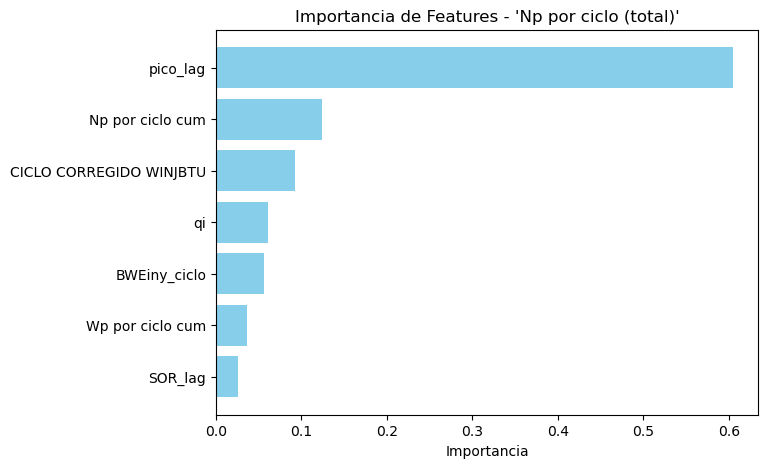


--- Importancia de Features para la salida 'PIR por ciclo' ---
BWEiny_ciclo: 0.6990
Wp por ciclo cum: 0.0696
Np por ciclo cum: 0.0603
qi: 0.0555
pico_lag: 0.0523
SOR_lag: 0.0392
CICLO CORREGIDO WINJBTU: 0.0241


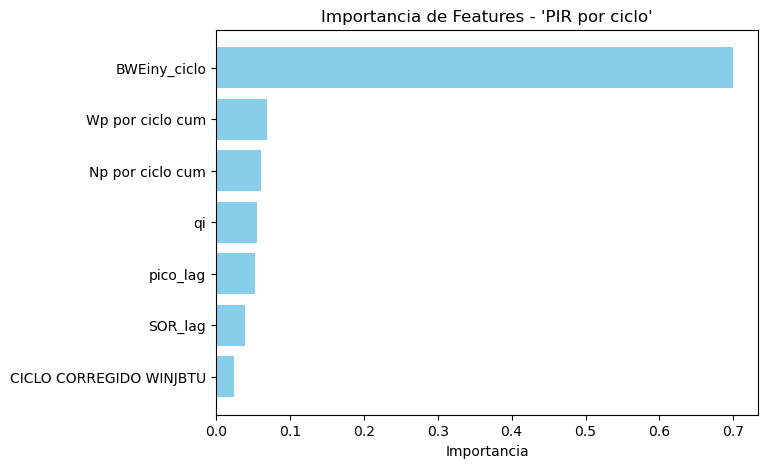

In [2]:
##################################################
# IMPORTANCIA DE FEATURES
##################################################

for i, est in enumerate(model_multi.estimators_):
    best_rf = est.best_estimator_
    importances = best_rf.feature_importances_
    feat_imp = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)
    
    print(f"\n--- Importancia de Features para la salida '{target_cols[i]}' ---")
    for (feat, imp) in feat_imp:
        print(f"{feat}: {imp:.4f}")

    # Gráfico de barras horizontales
    plt.figure(figsize=(7, 5))
    labels = [x[0] for x in feat_imp]
    vals = [x[1] for x in feat_imp]
    plt.barh(labels, vals, color='skyblue')
    plt.gca().invert_yaxis()
    plt.xlabel("Importancia")
    plt.title(f"Importancia de Features - '{target_cols[i]}'")
    plt.show()

## 5. Función evaluar_inyeccion

- Recibe la información del ciclo anterior (qi_lag, wp_lag, np_lag, pico_lag, etc.) y la inyección planeada en el nuevo ciclo (bweiny_ciclo), más el ciclo_actual.

- Construye un DataFrame con las columnas feature_cols.
- Llama a modelo.predict(...):
- Devuelve la predicción de [Np, PIR] para ese ciclo nuevo.
- Calcula SOR_calculado = bweiny_ciclo / np_pred.

In [3]:
##################################################
# SECCIÓN 4: FUNCIÓN EVALUAR INYECCION
##################################################

def evaluar_inyeccion(
    ciclo_actual,
    qi_lag,
    wp_lag,
    np_lag,
    bweiny_ciclo,
    sor_lag,
    pico_lag,
    modelo
):
    """
    Variables de entrada (features):
      - ciclo_actual => 'CICLO CORREGIDO WINJBTU'
      - qi_lag
      - wp_lag => 'Wp por ciclo cum'
      - np_lag => 'Np por ciclo cum'
      - bweiny_ciclo => 'BWEiny_ciclo'
      - sor_lag => 'SOR_lag'
      - pico_lag => 'pico_lag' (PICO DE PRODUCCIÓN del ciclo anterior)
    Retorna Np_pred, PIR_pred, y un SOR_calculado (bweiny_ciclo / Np_pred).
    """

    # Creamos la fila para el nuevo ciclo
    nueva_instancia = pd.DataFrame([[
        ciclo_actual,
        qi_lag,
        wp_lag,
        np_lag,
        bweiny_ciclo,
        sor_lag,
        pico_lag
    ]],
    columns=feature_cols)

    preds = modelo.predict(nueva_instancia)[0]
    np_pred, pir_pred = preds  # [Np, PIR]

    if np_pred != 0:
        sor_calculado = bweiny_ciclo / np_pred
    else:
        sor_calculado = float('inf')

    return {
        'Np_pred': np_pred,
        'PIR_pred': pir_pred,
        'SOR_calculado': sor_calculado
    }

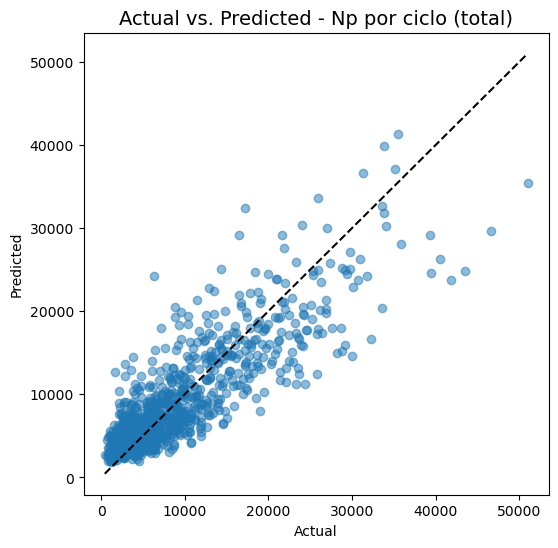

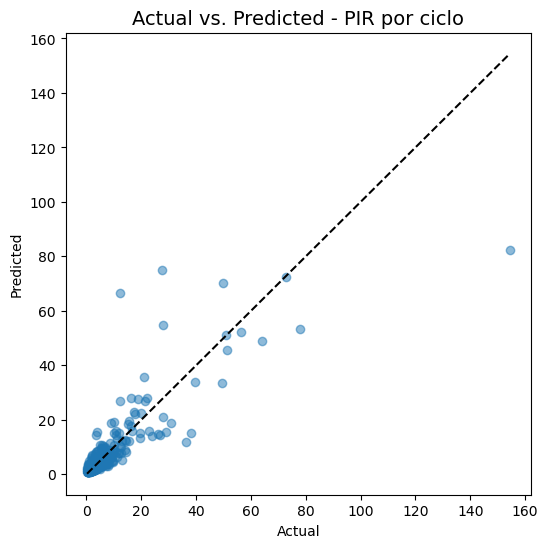

In [4]:
##################################################
# GRAFICAR VALORES REALES VS PREDICHOS
##################################################

for i, col in enumerate(target_cols):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5)
    plt.title(f"Actual vs. Predicted - {col}", fontsize=14)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    mini = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
    maxi = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
    plt.plot([mini, maxi], [mini, maxi], 'k--')
    plt.show()


Escenarios evaluados:
    Ciclo  qi_lag  Wp_lag  Np_lag  BWEiny_ciclo  SOR_lag  pico_lag  \
0      7   72.83  104762   70591          7438   0.0546     93.97   
1      8   64.19  130782   84675          3885   0.5281    120.48   
2      9   34.80  152608   90791          7589   0.6352     39.43   
3     10   22.67  165349   95168         11196   1.7339     33.03   
4     11   25.42  181499  170000         14639   1.7352     36.42   

        Np_pred  PIR_pred  SOR_calculado  
0  10548.205501  3.687177       0.705144  
1  10637.581825  9.032759       0.365215  
2   6559.653631  2.753305       1.156921  
3   6054.492281  1.893767       1.849205  
4   7091.722187  1.692343       2.064238  


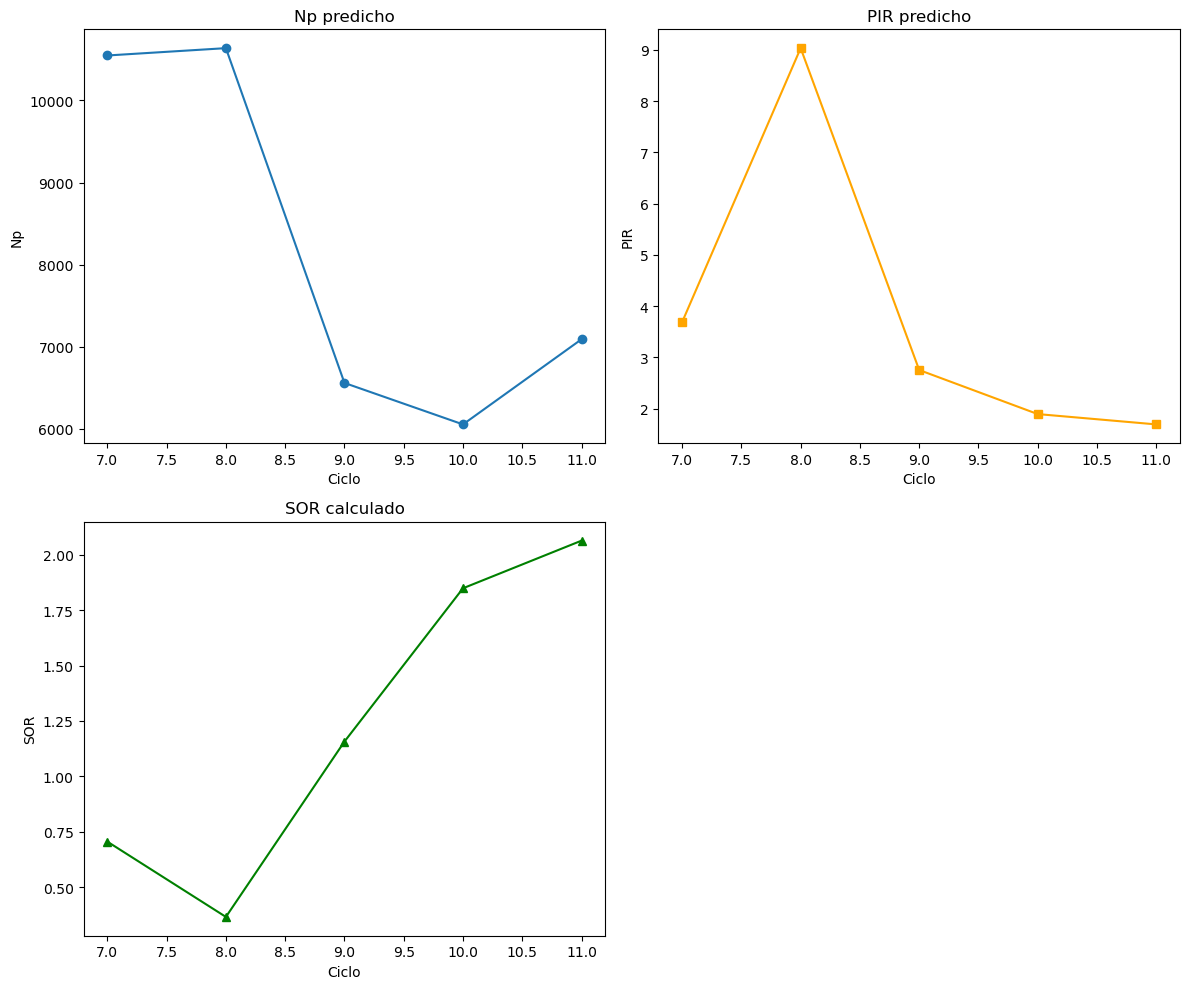

In [9]:
##################################################
# OPCIONAL: EJEMPLO DE ESCENARIOS
##################################################

escenarios = [
    dict(ciclo=7,  qi=72.83, wp=104762, np=70591,  bweiny=7438,   sor=0.0546, pico_lag=93.97),
    dict(ciclo=8,  qi=64.19, wp=130782, np=84675,  bweiny=3885,   sor=0.5281, pico_lag=120.48),
    dict(ciclo=9,  qi=34.8, wp=152608, np=90791,  bweiny=7589,   sor=0.6352, pico_lag=39.43),
    dict(ciclo=10, qi=22.67,  wp=165349, np=95168,  bweiny=11196,  sor=1.7339, pico_lag=33.03),
    dict(ciclo=11, qi=25.42, wp=181499, np=109891, bweiny=14639,  sor=1.7352, pico_lag=36.42)
]

resultados = []
for esc in escenarios:
    res = evaluar_inyeccion(
        ciclo_actual=esc["ciclo"],
        qi_lag=esc["qi"],
        wp_lag=esc["wp"],
        np_lag=esc["np"],
        bweiny_ciclo=esc["bweiny"],
        sor_lag=esc["sor"],
        pico_lag=esc["pico_lag"],
        modelo=model_multi
    )
    fila = {
        "Ciclo": esc["ciclo"],
        "qi_lag": esc["qi"],
        "Wp_lag": esc["wp"],
        "Np_lag": esc["np"],
        "BWEiny_ciclo": esc["bweiny"],
        "SOR_lag": esc["sor"],
        "pico_lag": esc["pico_lag"],
        "Np_pred": res["Np_pred"],
        "PIR_pred": res["PIR_pred"],
        "SOR_calculado": res["SOR_calculado"]
    }
    resultados.append(fila)

df_escenarios = pd.DataFrame(resultados)
print("\nEscenarios evaluados:\n", df_escenarios)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Subplot (0,0): Np_pred
axes[0,0].plot(df_escenarios["Ciclo"], df_escenarios["Np_pred"], marker='o', label="Np_pred")
axes[0,0].set_title("Np predicho")
axes[0,0].set_xlabel("Ciclo")
axes[0,0].set_ylabel("Np")

# Subplot (0,1): PIR_pred
axes[0,1].plot(df_escenarios["Ciclo"], df_escenarios["PIR_pred"], marker='s', color='orange', label="PIR_pred")
axes[0,1].set_title("PIR predicho")
axes[0,1].set_xlabel("Ciclo")
axes[0,1].set_ylabel("PIR")

# Subplot (1,0): SOR_calculado
axes[1,0].plot(df_escenarios["Ciclo"], df_escenarios["SOR_calculado"], marker='^', color='green', label="SOR_calculado")
axes[1,0].set_title("SOR calculado")
axes[1,0].set_xlabel("Ciclo")
axes[1,0].set_ylabel("SOR")

axes[1,1].axis('off')

plt.tight_layout()
plt.show()


Escenarios evaluados:
    Ciclo  qi_lag    Wp_lag    Np_lag  BWEiny_ciclo  SOR_lag  pico_lag  \
0      3   22.97  13142.37  35868.28        9466.2   0.2744    146.84   
1      4   42.77  34177.57  56226.68        7730.1   0.4649     99.47   
2      5   32.74  51902.91  66531.01        8912.7   0.7501     55.77   
3      6   38.52  65078.23  73257.32        1034.1   1.3250     56.68   
4      7   55.94  79117.10  81328.66        8135.1   0.1281     55.94   

        Np_pred   PIR_pred  SOR_calculado  
0  14121.345925   2.934291       0.670347  
1  11669.827298   3.548815       0.662401  
2   9719.214960   2.384037       0.917019  
3   9338.996080  25.963194       0.110729  
4   9875.056601   2.691596       0.823803  


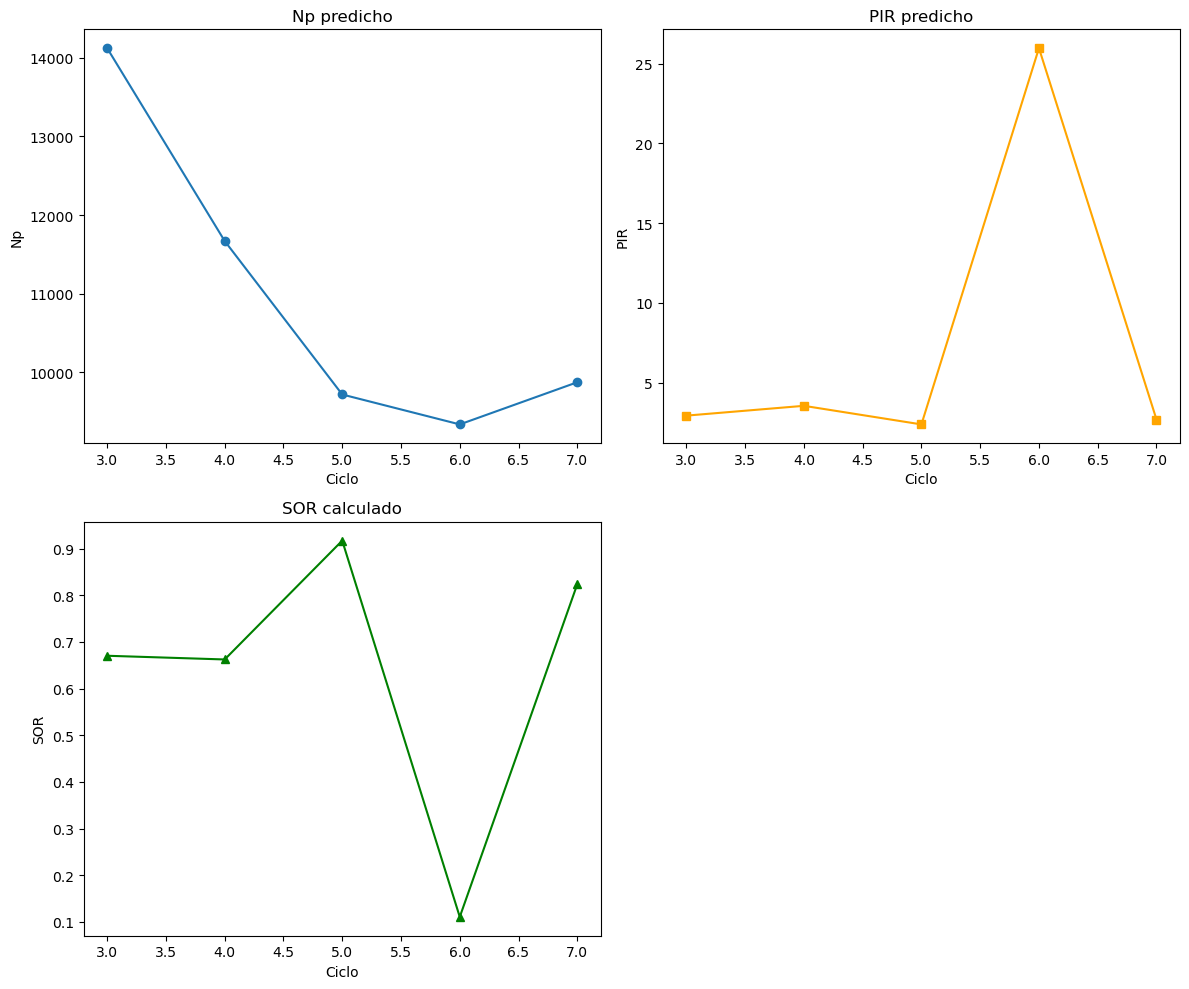

In [12]:
##################################################
# OPCIONAL: EJEMPLO DE ESCENARIOS
##################################################

escenarios = [
    dict(ciclo=3,  qi=22.97, wp=13142.37, np=35868.28,  bweiny=9466.2,   sor=0.2744, pico_lag=146.84),
    dict(ciclo=4,  qi=42.77, wp=34177.57, np=56226.68,  bweiny=7730.1,   sor=0.4649, pico_lag=99.47),
    dict(ciclo=5,  qi=32.74, wp=51902.91, np=66531.01,  bweiny=8912.7,   sor=0.7501, pico_lag=55.77),
    dict(ciclo=6, qi=38.52,  wp=65078.23, np=73257.32,  bweiny=1034.1,  sor=1.3250, pico_lag=56.68),
    dict(ciclo=7, qi=55.94, wp=79117.1, np=81328.66, bweiny=8135.1,  sor=0.1281, pico_lag=55.94)
]

resultados = []
for esc in escenarios:
    res = evaluar_inyeccion(
        ciclo_actual=esc["ciclo"],
        qi_lag=esc["qi"],
        wp_lag=esc["wp"],
        np_lag=esc["np"],
        bweiny_ciclo=esc["bweiny"],
        sor_lag=esc["sor"],
        pico_lag=esc["pico_lag"],
        modelo=model_multi
    )
    fila = {
        "Ciclo": esc["ciclo"],
        "qi_lag": esc["qi"],
        "Wp_lag": esc["wp"],
        "Np_lag": esc["np"],
        "BWEiny_ciclo": esc["bweiny"],
        "SOR_lag": esc["sor"],
        "pico_lag": esc["pico_lag"],
        "Np_pred": res["Np_pred"],
        "PIR_pred": res["PIR_pred"],
        "SOR_calculado": res["SOR_calculado"]
    }
    resultados.append(fila)

df_escenarios = pd.DataFrame(resultados)
print("\nEscenarios evaluados:\n", df_escenarios)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Subplot (0,0): Np_pred
axes[0,0].plot(df_escenarios["Ciclo"], df_escenarios["Np_pred"], marker='o', label="Np_pred")
axes[0,0].set_title("Np predicho")
axes[0,0].set_xlabel("Ciclo")
axes[0,0].set_ylabel("Np")

# Subplot (0,1): PIR_pred
axes[0,1].plot(df_escenarios["Ciclo"], df_escenarios["PIR_pred"], marker='s', color='orange', label="PIR_pred")
axes[0,1].set_title("PIR predicho")
axes[0,1].set_xlabel("Ciclo")
axes[0,1].set_ylabel("PIR")

# Subplot (1,0): SOR_calculado
axes[1,0].plot(df_escenarios["Ciclo"], df_escenarios["SOR_calculado"], marker='^', color='green', label="SOR_calculado")
axes[1,0].set_title("SOR calculado")
axes[1,0].set_xlabel("Ciclo")
axes[1,0].set_ylabel("SOR")

axes[1,1].axis('off')

plt.tight_layout()
plt.show()

# Comparación gráficos con datos reales en excel
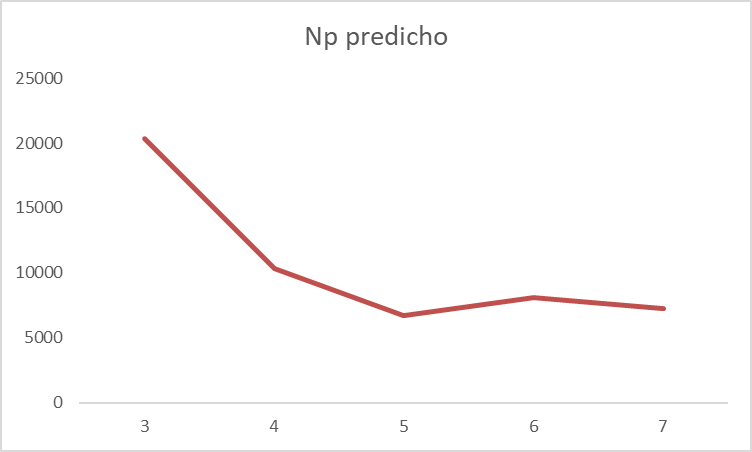
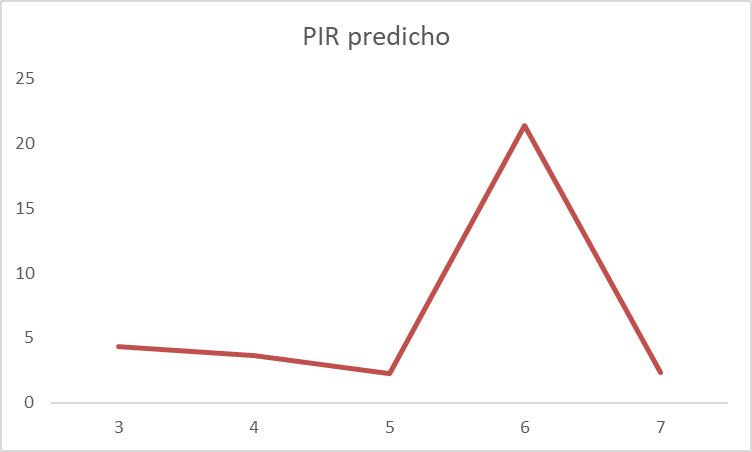
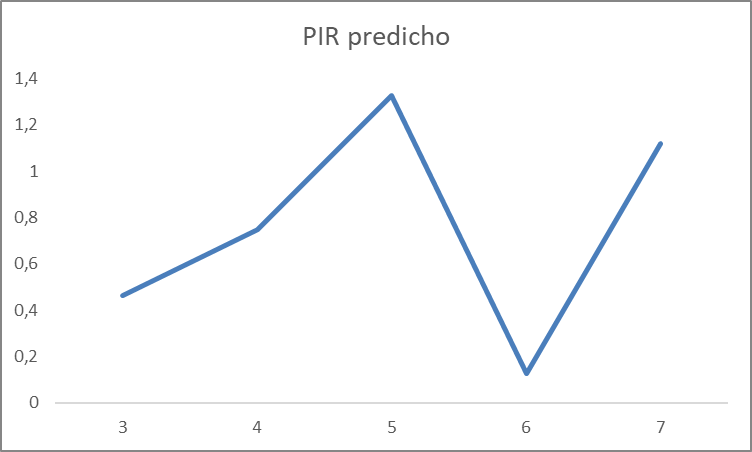